<h1><center>Machine Learning Project - AVAZU<center></h1>


## Project Setup

In [1]:
import sys
from zipfile import ZipFile
import os.path as op
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

AVAZU_URL = "https://bianchi.wp.imt.fr/files/2019/05/train-1000000.zip"
AVAZU_FILENAME = AVAZU_URL.rsplit('/', 1)[1]


if not op.exists(AVAZU_FILENAME):
    print('Downloading %s to %s...' % (AVAZU_URL, AVAZU_FILENAME))
    urlretrieve(AVAZU_URL, AVAZU_FILENAME)
    ZipFile(AVAZU_FILENAME).extractall('.')

In [2]:
ZipFile(AVAZU_FILENAME).extractall('.')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

Data description here: https://www.kaggle.com/c/avazu-ctr-prediction/data  


## Work assignment

1.   Perform Exploratory Data Analysis (EDA)
2.   Predict the probability that an add is clicked, based on the features.
3.   Evaluate the performance of your method.

##Work evaluation

Your work will be evaluated based on:

*   The interest of the EDA (4 points)
*   The quality of the comments/remarks throughout the notebook (4 points)
*   The feature engineering (5 points)
*   The efforts made in trying several predictors and tuning them (5 points)
*   The relevance of the performance criteria used to conclude (2 points)
*   BONUS (+1pt) : Register to the AVAZU challenge in Kaggle. What is your rank?

You may find the following script useful to convert the raw time stamp into a more useable feature. For instance, you may generate new pandas series using the code:

```
df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'].apply(lambda x:datesplit(x).hour)
```



## EDA

### ***Missing Values***   


Upon inital inspection, there are no missing values. All 1 million rows of the 24 attributes have values. The ID column is dropped because it is unique to every single entry and thus does not offer much information that can be used in models.   
We see that the dataset contains 23 attributes after dropping ID and 1 million entries.

In [5]:
df = pd.read_csv('train-1000000')
#drop ID column
df.drop('id', axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   click             1000000 non-null  int64 
 1   hour              1000000 non-null  int64 
 2   C1                1000000 non-null  int64 
 3   banner_pos        1000000 non-null  int64 
 4   site_id           1000000 non-null  object
 5   site_domain       1000000 non-null  object
 6   site_category     1000000 non-null  object
 7   app_id            1000000 non-null  object
 8   app_domain        1000000 non-null  object
 9   app_category      1000000 non-null  object
 10  device_id         1000000 non-null  object
 11  device_ip         1000000 non-null  object
 12  device_model      1000000 non-null  object
 13  device_type       1000000 non-null  int64 
 14  device_conn_type  1000000 non-null  int64 
 15  C14               1000000 non-null  int64 
 16  C15               1

In [6]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,...,1,2,4687,320,50,423,2,39,100148,32
1,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,17894,320,50,2039,2,39,100077,32
2,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,...,1,0,22684,320,50,2619,1,163,100055,71
3,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,...,1,0,23222,320,50,2676,0,35,100176,221
4,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,8330,320,50,761,3,175,100081,23


### ***Class Inbalance***  


Even though click is stored as a int64, it really is a binary value. We take the average to understand on average, what percentage of views are clicked on. We see that less than 17% are clicked, telling us that the results are inbalanced. In cases like this, accuracy may not be the best metric to evaluate our model performance. We can consider other metrics such as AUC of the ROC.

In [7]:
df.describe()

,click,hour,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.169971,1.410256e+07,1004.968549,0.288466,1.015506,0.332436,18835.759473,318.888112,60.030918,2111.794488,1.432802,226.940103,53163.356361,83.404070
std,0.375608,2.966148e+02,1.096112,0.505974,0.527867,0.856103,4966.228494,21.279475,47.174174,610.393836,1.325815,350.944666,49960.216178,70.326773
min,0.000000,1.410210e+07,1001.000000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000
25%,0.000000,1.410230e+07,1005.000000,0.000000,1.000000,0.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000
50%,0.000000,1.410260e+07,1005.000000,0.000000,1.000000,0.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100048.000000,61.000000
75%,0.000000,1.410281e+07,1005.000000,1.000000,1.000000,0.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100088.000000,101.000000
max,1.000000,1.410302e+07,1012.000000,7.000000,5.000000,5.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000


### N categories

Treating every variable as categorical, I want to understand roughly how many of those with a large number of categories have very little entries. These entries are most likely going to decrease our model performance. In later feature engineering efforts, we may be able to consider all those that are lesser than a specific threshold as the same category. This will be easier for methods such as one hot encoding that will help some models that are more sensitive to overfitting such as neural networks.

In [8]:
df.nunique()

,0
click,2
hour,240
C1,7
banner_pos,7
site_id,2651
site_domain,2871
site_category,22
app_id,3157
app_domain,198
app_category,26


In [9]:
#site_id has 2651 unique values, and 1198 site_ids only have less than 5 entries
less_than_5_site_id = df['site_id'].value_counts().value_counts()[0:5].sum()
less_than_5_site_id

df['site_id'].value_counts().head()

,count
site_id,
85f751fd,360911
1fbe01fe,159924
e151e245,65231
d9750ee7,24090
5b08c53b,22524


In [10]:
#site_domain has 2871 unique values, and 1621 site_ids only have less than 5 entries
less_than_5_site_domain = df['site_domain'].value_counts().value_counts()[0:5].sum()
less_than_5_site_domain

df['site_domain'].value_counts().head()

,count
site_domain,
c4e18dd6,374158
f3845767,159924
7e091613,82263
7687a86e,31858
98572c79,24879


site_id and site_domain seem to match up in terms of distribution. This is important to note because they might be highly correlated with each other. Unlike the app_id, device_id, and device_ip, I don't think these are missing entries because the second most and the third most are still in the same order of magnitude.

In [11]:
#app_id has 3157 unique values, and 1994 site_ids only have less than 5 entries
less_than_5_app_id = df['app_id'].value_counts().value_counts()[0:5].sum()
less_than_5_app_id

df['app_id'].value_counts().head()

,count
app_id,
ecad2386,639089
92f5800b,38643
e2fcccd2,28008
9c13b419,18820
febd1138,18726


Note that the top site ecad2386 has 64% of all rows and is almost 20X the amount of the second most one. It is possible that the same ad is heavily advertised on the same app, so I will keep this in mind.

In [12]:
#device_id has 150501 unique values, and 149981 site_ids only have less than 5 entries.
less_than_5_device_id = df['device_id'].value_counts().value_counts()[0:5].sum()
less_than_5_device_id

#This is interesting because it means that a few devices contributed to a lot of the entries
df['device_id'].value_counts().head()

,count
device_id,
a99f214a,824918
0f7c61dc,512
c357dbff,481
936e92fb,366
afeffc18,242


It is highly unlikely that one device makes up for 82% of the entire dataset. I therefore will go on thinking about a99f214a as missing entry. This will be handled in the feature engineering section

In [13]:
#device_ip has 150501 unique values, and 536089 device_ips only have less than 5 entries
less_than_5_device_ip = df['device_ip'].value_counts().value_counts()[0:5].sum()
print(less_than_5_device_ip)

#This is interesting because it means that a few devices contributed to a lot of the entries
df['device_ip'].value_counts().head()

536089


,count
device_ip,
6b9769f2,5130
431b3174,3291
2f323f36,2197
930ec31d,2196
285aa37d,2181


In [14]:
#device_id has 5186 unique values, and 1986 site_ids only have less than 5 entries
less_than_5_device_model = df['device_model'].value_counts().value_counts()[0:5].sum()
print(less_than_5_device_model)

#This is interesting because it means that a few devices contributed to a lot of the entries
df['device_model'].value_counts().head()

1986


,count
device_model,
8a4875bd,60790
1f0bc64f,35103
d787e91b,34780
76dc4769,18663
be6db1d7,18357


### ***Initial Feature Engineering for Hour Column***   


Here we take interest in the hour column. Hour looks to represent the time in which the clicks were made. We use the datetime package to split the hour column into more columns. This will allow us to look at year, month, day, and time of day's impact on clickrate is individually.

We split the hour column into day of the week and hour of the day and disregard the year and month. The hypothesis is that the year and month will have no effect on clickrate. However, this is not explicitly tested.

We now look at each day of the week's correlation with clickrate. We can see clear groups. People click the least on Tuesdays and Wednesdays (16%), then Thursdays and Fridays (17.4%), and highest on Saturdays, Sundays, and Mondays (18.4%). However, since the mean is less than 17% for the entire dataset, it is clear that ***there are much more visits on Tuesdays and Wednesdays than there are on Weekends.***

We now look at each hour of the day's correlation with the clickrate. ***We can see that there are 3 spikes in clickrate throughout the day, at 1am, 7am, and 3pm and 3 lowpoints throughout the day at 4am, 9am, and 8pm.*** It isn't clear why the data behaves this way but it is worth noting.

Lastly, to see if this behaviour is consistent throughout the week, we look at the clickrate for each hour for each day. We find that although this time the spread is less similar, there is still the consistent three spikes at roughly the same times, ***most apparent of all there is a huge spike everyday around the 1am mark.***


In [15]:
df['hour'].head()

,hour
0,14102915
1,14103007
2,14102711
3,14102903
4,14102902


In [16]:
import datetime
def datesplit(originalDate):
    originalDate = str(originalDate)

    year = int("20" + originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])

    return datetime.datetime(year, month, day, hour)

# Example :
datesplit(14102915).weekday(), datesplit(14102915).hour

(2, 15)

In [17]:
df['hour'] = df['hour'].astype(str)

In [18]:
#transform hour column into day of the week and hour
df['weekday'] = df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x:datesplit(x).hour)

In [19]:
#weekday is from 1-7, but the indexing starts from 0, so start 1
df['weekday'] += 1
df['weekday'].unique() #there are indeed 7 days in a week

array([3, 4, 1, 5, 6, 7, 2])

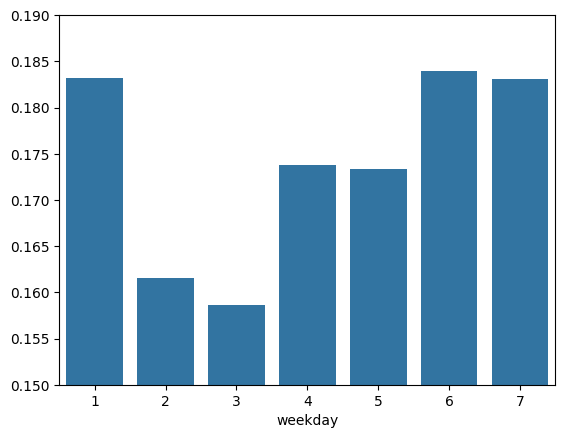

In [20]:
#look at correlation of weekday to click rate
click_rates_day = df.groupby('weekday')['click'].mean()

# Create the bar plot with the specified y-axis limits
ax = sns.barplot(x=click_rates_day.index, y=click_rates_day.values)
ax.set_ylim(0.150, 0.190)  # Set y-axis limits

plt.show()

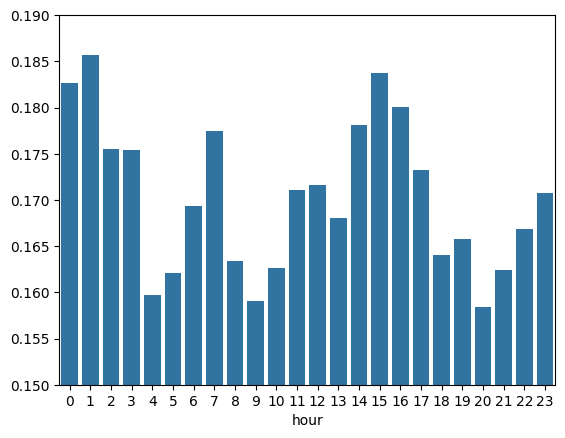

In [21]:
#look at correlation of hour of the day to click rate
click_rates_hour = df.groupby('hour')['click'].mean()

ax = sns.barplot(x = click_rates_hour.index, y = click_rates_hour.values)
ax.set_ylim(0.150, 0.190)  # Set y-axis limits

plt.show()

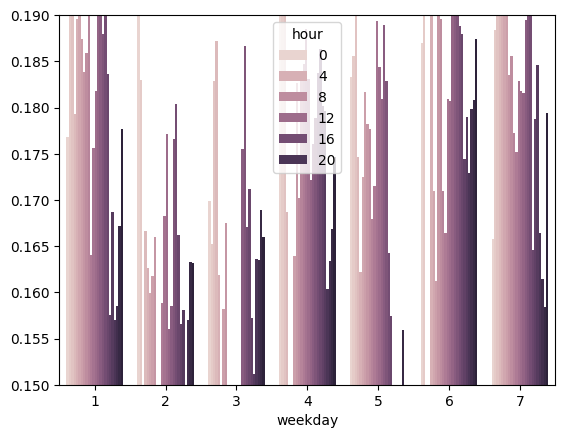

In [22]:
click_rates_hour_day = df.groupby(['weekday', 'hour'])['click'].mean()

ax = sns.barplot(x=click_rates_hour_day.index.get_level_values(0), y=click_rates_hour_day.values, hue = click_rates_hour_day.index.get_level_values(1))
ax.set_ylim(0.150, 0.190)  # Set y-axis limits

plt.show() # Show the plot

###Importance

In [23]:
def get_frequency_ctr(df, column, top_n):
   """
   Get frequency and CTR for top N categories of a specified column

   Args:
       df: DataFrame
       column: Column name to analyze
       top_n: Number of top categories to return

   Returns:
       DataFrame with frequency and CTR for top N categories
   """
   # Get frequency
   frequency = (df[column].value_counts()/len(df)).reset_index()
   frequency.columns = [column, 'frequency']
   frequency = frequency.head(top_n)

   # Get CTR
   ctr = df.groupby(column)['click'].mean().reset_index()
   ctr.columns = [column, 'ctr']

   # Merge and sort by frequency
   result = frequency.merge(ctr, on=column).sort_values('frequency', ascending=False)

   #get cumulative percentage
   result['cumulative_percentage'] = result['frequency'].cumsum()
   result['cumulative_percentage'] = result['cumulative_percentage'] / result['frequency'].sum()

   return result

####C1
1005 is 92% of the data and has mean CTR.   
1002 is 5.5% of the data and has a CTR of 21%.   
1010 is 2.2% of the data and has a 9% CTR

In [24]:
get_frequency_ctr(df, "C1", 10)

,C1,frequency,ctr,cumulative_percentage
0,1005,0.918606,0.169474,0.918606
1,1002,0.054907,0.211157,0.973513
2,1010,0.022409,0.095497,0.995922
3,1012,0.002854,0.177295,0.998776
4,1007,0.000871,0.035591,0.999647
5,1001,0.000222,0.027027,0.999869
6,1008,0.000131,0.106870,1.000000


####Banner
99.8% of the banner positions are either 0 or 1.
banner position 0 is 72% of the data and has a CTR of 0.164.  
banner position 1 is 28% of the data and has a CTR of 0.184

In [25]:
get_frequency_ctr(df, "banner_pos", 10)

,banner_pos,frequency,ctr,cumulative_percentage
0,0,0.719444,0.164342,0.719444
1,1,0.278805,0.184086,0.998249
2,7,0.001074,0.312849,0.999323
3,2,0.000326,0.107362,0.999649
4,4,0.000176,0.119318,0.999825
5,5,0.000131,0.106870,0.999956
6,3,0.000044,0.136364,1.000000


####Device Type
We can see that device 0 is 5.5% of the data, which is not insignificant, but has a significantly larger CTR of 0.21.
Device 1 is the most common device, taking up 92% of the data, and has the mean CTR.   

In [26]:
get_frequency_ctr(df, "device_type", 10)

,device_type,frequency,ctr,cumulative_percentage
0,1,0.922683,0.169329,0.922683
1,0,0.054907,0.211157,0.977590
2,4,0.019224,0.096546,0.996814
3,5,0.003185,0.089168,0.999999
4,2,0.000001,0.000000,1.000000


####device conn type
  
connection type 0 is 82% of the data, with a CTR of 18%
All other connection types have lower than mean CTR, with 3 and 5 especially low, in the single digit percentages.

In [27]:
get_frequency_ctr(df, "device_conn_type", 10)

,device_conn_type,frequency,ctr,cumulative_percentage
0,0,0.862492,0.181407,0.862492
1,2,0.082186,0.135279,0.944678
2,3,0.054273,0.043558,0.998951
3,5,0.001049,0.025739,1.000000


####site category
The top 5 site categories make up 99% of the data. In partiuclar, the top catgory that makes up for 41% of the data only has a 12.8% CTR. The 4th most site category taking up 7.5% has a 28% CTR.

In [28]:
get_frequency_ctr(df, "site_category", 10)

,site_category,frequency,ctr,cumulative_percentage
0,50e219e0,0.408921,0.128597,0.409763
1,f028772b,0.313339,0.179719,0.723747
2,28905ebd,0.182020,0.208076,0.906142
3,3e814130,0.075667,0.284245,0.981965
4,f66779e6,0.006365,0.034564,0.988343
5,75fa27f6,0.004007,0.111305,0.992358
6,335d28a8,0.003351,0.089824,0.995716
7,76b2941d,0.002573,0.035756,0.998294
8,c0dd3be3,0.001026,0.128655,0.999323
9,72722551,0.000676,0.059172,1.000000


####site id

In [29]:
get_frequency_ctr(df, "site_id", 11)

,site_id,frequency,ctr,cumulative_percentage
0,85f751fd,0.360911,0.118783,0.509706
1,1fbe01fe,0.159924,0.205516,0.735563
2,e151e245,0.065231,0.297972,0.827687
3,d9750ee7,0.024090,0.274180,0.861709
4,5b08c53b,0.022524,0.469677,0.893519
5,856e6d3f,0.018974,0.044060,0.920315
6,5b4d2eda,0.018613,0.132703,0.946602
7,a7853007,0.011457,0.103256,0.962782
8,b7e9786d,0.009149,0.074544,0.975703
9,5ee41ff2,0.008705,0.328662,0.987997


## Benchmark Logistic Regression Model

The benchmark logistic regressin model does not converge and python shows that the number of iterations has reached limit. The benchmark model achieved an AUC score of 0.611. Consequent efforts will be made to improve focusing on the AUC score.

In [31]:
#create baseline logistic regression model
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, log_loss, precision_score, recall_score, f1_score

In [32]:
LR_bench = LogisticRegression()

#training set and testing set
#for initial attributes, only include attributes with int values
initial_lr_attributes = ['hour', 'C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday']
y = df['click']
X = df[initial_lr_attributes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

model = LR_bench.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_prob = model.predict_proba(X_test)[:, 1]
neg_log_loss = log_loss(y_test, y_prob)

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


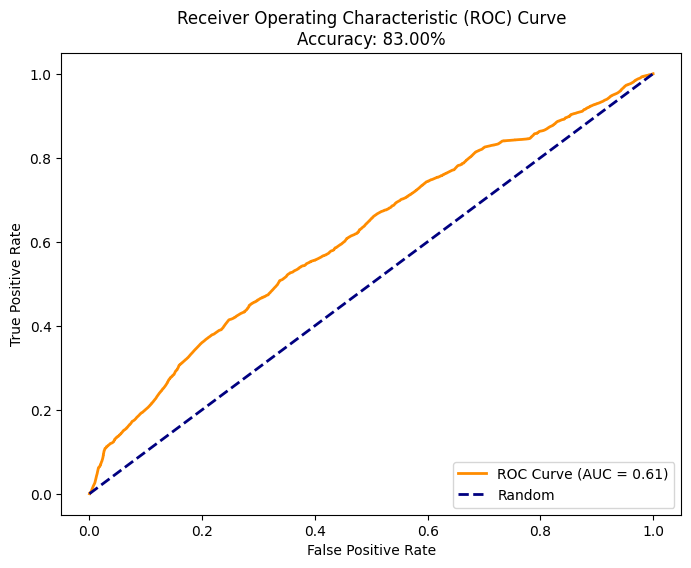

In [33]:
#plot roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

In [34]:
def calculate_power_from_confusion_matrix(y_true, y_pred):
    # Get confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calculate power (same as sensitivity/recall/TPR)
    power = tp / (tp + fn)

    # Calculate other relevant metrics
    fpr = fp / (fp + tn)  # alpha (Type I error rate)
    fnr = fn / (tp + fn)  # beta (Type II error rate)

    return power

In [35]:
#Various metrics to account for

base_model_nll = neg_log_loss
cr = classification_report(y_test, y_pred, output_dict = True)
precision_class1 = cr['1']['precision']
recall_class1 = cr['1']['recall']
f1_class1 = cr['1']['f1-score']
power = calculate_power_from_confusion_matrix(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Model': ['Base Logistic Regression Model'],
    'auc': [roc_auc],
    'Loss' : ['negative log loss'],
    'Loss Value': [base_model_nll],
    'Precision': [precision_class1],
    'Recall': [recall_class1],
    'F1 Score': [f1_class1],
    'Power': [power]
})

# Round numeric columns to 3 decimal places
numeric_columns = ['auc', 'Loss Value', 'Precision', 'Recall', 'F1 Score', 'Power']
metrics_df[numeric_columns] = metrics_df[numeric_columns].round(3)

metrics_df

,Model,auc,Loss,Loss Value,Precision,Recall,F1 Score,Power
0,Base Logistic Regression Model,0.611,negative log loss,0.442,0.205,0.003,0.006,0.003


In [36]:
metrics_df.head()

,Model,auc,Loss,Loss Value,Precision,Recall,F1 Score,Power
0,Base Logistic Regression Model,0.611,negative log loss,0.442,0.205,0.003,0.006,0.003


##Feature Engineering

###Site ID CTR Grouping
We start by tackling higher dimensional features such as site_id. site_id contains 2651 unique entries, with more than 1900 of those sites having less than 5 entries. This would mean that grouping purely based on click through rate would likely be unreliable. The two primary goals are to group the site_ids by quantile instead of setting an arbiturary boundary, and to smooth out extreme click through rates from sites that have lesser entries.   
We use empirical bayes estimation to shrink extreme click through rates towards the global mean for sites that have less entries.   
Step 1: Calcualte α and β parameters for β distribution using method of moments.
*   α and β represents the expected clicks and non-clicks respectively, with the sum of the two representing the degree of confidence we have in our estimation. The sum is called the effective sample size. Greater effective sample siezes would pull values with lesser entries more towards the mean. In this project, α / (α + β) should be 0.169.
*  The β distribution is a probability distribution parameterized by α and β representing all values CTR could take, bounded by 0 and 1.
*   method of moments estimation fits the β distribution's known mean and variance formula (Mean = α/(α + β);
Variance = (α * β)/((α + β)²(α + β + 1))) to the measured mean and variance in the sample.   

Step 2: calculate the smoothed CTR, group, and confidence of smoothed CTR.
*  smoothed CTR is calculated by fitting the empirical CTR onto the β distribution
*  group the entries by quantile, in this case, we set the qunatiles to 12.
*  confidence of the smoothed CTR is largely dependent on the # of impressions in the dataset.  

Step 3: Validate if site CTR remain stable through different time frames
*  We sort the data by its temporal quality, sorting by hours of the day. Then, we obtain a dataframe with columns consisting of the 3 splits of hours of the day and rows representing each unique site_id. At the end, we attach the standard deviation for each time split's smoothed CTR and the range. We use these two metrics to evaluate the stability of each site temporally.

Step 4: Taking a look at those with high ranges
* we find that out of the 1 million instances, 1322 instances have over 0.01 in difference when examined through different time periods. This will hopefully be addressed when temporal engineering next.


In [37]:
from scipy import stats

In [38]:
def calculate_beta_parameters(df, click_col = 'click', group_col = 'site_id'):
  """
  Calculate alpha and beta parameters for beta distribution using method of moments.

  Returns:
  tuple (alpha, beta) : parameters for beta distribution
  """

  #Global mean and variace CTR
  site_stats = df.groupby(group_col).agg({
      click_col: ['count', 'mean']
  }).reset_index()

  site_stats.columns = [group_col, 'impressions', 'ctr']

  # Method of moments estimation
  mean = site_stats['ctr'].mean()
  var = site_stats['ctr'].var()

  # Calculate alpha and beta
  if var == 0:
      return 1, 1

  alpha = mean * (mean * (1 - mean) / var - 1)
  beta = (1 - mean) * (mean * (1 - mean) / var - 1)

  return alpha, beta

In [39]:
def create_features(df, click_col = 'click', group_col = 'site_id', n_groups = 12, min_impressions = 1):
  """
  create features using Empirical Bayes smoothing and quantile-based grouping.

  Parameters:
  df: input dataframe
  click_col: y
  group_col: column to be grouped
  n_groups: number of groups to be created, in this case using quantile based grouping
  min_impressions: minimum number of impressions required for reliable CTR calculation

  Returns:
  df with
    raw_ctr: original CTR
    smoothed_ctr: smoothed CTR
    ctr_group: group assignment based on smoothed CTR
    impression_count: number of impressions
  """

  # Calculate global statistics
  site_stats = df.groupby(group_col).agg({
      click_col: ['count', 'sum']
  }).reset_index()

  site_stats.columns = [group_col, 'impressions', 'clicks']

  # Calculate raw CTR
  site_stats['raw_ctr'] = site_stats['clicks'] / site_stats['impressions']

  # Get beta distribution parameters
  alpha, beta = calculate_beta_parameters(df, click_col, group_col)

  # Calculate smoothed CTR using Empirical Bayes
  site_stats['smoothed_ctr'] = (alpha + site_stats['clicks']) / (alpha + beta + site_stats['impressions'])

  # try to get unique quantiles
  _, bins = pd.qcut(site_stats['smoothed_ctr'], q=n_groups, retbins=True, duplicates='drop')
  # Create labels based on actual number of bins
  labels = [f'group_{i}' for i in range(len(bins)-1)]
  # Apply the binning
  site_stats['ctr_group'] = pd.cut(
      site_stats['smoothed_ctr'],
      bins=bins,
      labels=labels,
      include_lowest=True
  )

  # Add confidence metrics
  site_stats['ctr_confidence'] = 1 - (1 / (1 + site_stats['impressions']))

    # Create feature dictionary for easy mapping
  feature_dict = {
      'raw_ctr': dict(zip(site_stats[group_col], site_stats['raw_ctr'])),
      'smoothed_ctr': dict(zip(site_stats[group_col], site_stats['smoothed_ctr'])),
      'ctr_group': dict(zip(site_stats[group_col], site_stats['ctr_group'])),
      'impression_count': dict(zip(site_stats[group_col], site_stats['impressions'])),
      'ctr_confidence': dict(zip(site_stats[group_col], site_stats['ctr_confidence']))
    }

  return feature_dict

In [40]:
def validate_grouping_stability(df, group_col = 'site_id', click_col = 'click', time_col = 'hour', n_splits = 3):
  """
  Validate stability of site groupings across hours

  Parameters
  df: pandas dataframe
  group_col: name of column to be grouped
  click_col: y parameter
  time_col: column containing time information
  n_splits: splitting time periods into n splits.

  Returns
  Dataframe with stability metrics for each site_id
  """
  #sort by time and create time periods
  df = df.sort_values(time_col)
  df['time_period'] = pd.qcut(df[time_col], q = n_splits, labels = range(n_splits))

  stability_metrics = []

  #Calculate CTR for each time period
  for period in range(n_splits):
    period_data = df[df['time_period'] == period]
    feature_dict = create_features(period_data, click_col, group_col)

    # Store smoothed CTR for each site
    period_ctrs = pd.DataFrame({
        group_col: list(feature_dict['smoothed_ctr'].keys()),
        f'ctr_period_{period}': list(feature_dict['smoothed_ctr'].values())
    })

    stability_metrics.append(period_ctrs)

    #Merge CTRs from all periods
    stability_df = stability_metrics[0]
    for i in range(1, len(stability_metrics)):
      stability_df = stability_df.merge(
          stability_metrics[i],
          on = group_col,
          how = 'outer'
      )

      #calculate stability metrics
      ctr_cols = [col for col in stability_df.columns if 'ctr_period_' in col]
      stability_df['ctr_std'] = stability_df[ctr_cols].std(axis = 1)
      stability_df['ctr_range'] = stability_df[ctr_cols].max(axis=1) - stability_df[ctr_cols].min(axis=1)

      return stability_df

In [41]:
feature_dict = create_features(df, click_col='click', group_col='site_id')

# Add features to main dataframe
df['site_smoothed_ctr'] = df['site_id'].map(feature_dict['smoothed_ctr'])
df['site_ctr_group'] = df['site_id'].map(feature_dict['ctr_group'])
df['site_ctr_confidence'] = df['site_id'].map(feature_dict['ctr_confidence'])

# Validate stability
stability_metrics = validate_grouping_stability(df)

In [42]:
stability_metrics[stability_metrics['ctr_range'] > 0.01]

,site_id,ctr_period_0,ctr_period_1,ctr_std,ctr_range
8,01270328,0.230921,0.202211,0.020301,0.028710
9,0129a661,0.585372,0.055200,0.374888,0.530172
11,014428c1,0.166187,0.027593,0.098001,0.138594
16,021cd138,0.266054,0.460444,0.137455,0.194390
18,02296256,0.232899,0.082821,0.106121,0.150078
...,...,...,...,...,...
2424,ffb2c209,0.081072,0.096876,0.011175,0.015804
2425,ffc6e801,0.053773,0.722207,0.472655,0.668435
2426,ffcb6b9a,0.178394,0.155352,0.016294,0.023043
2427,ffcff165,0.080900,0.309427,0.161593,0.228527


In [43]:
df.head(20)

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C16,C17,C18,C19,C20,C21,weekday,site_smoothed_ctr,site_ctr_group,site_ctr_confidence
0,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,...,50,423,2,39,100148,32,3,0.297969,group_8,0.999985
1,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,...,50,2039,2,39,100077,32,4,0.204206,group_7,0.988095
2,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,...,50,2619,1,163,100055,71,1,0.118783,group_6,0.999997
3,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,...,50,2676,0,35,100176,221,3,0.118783,group_6,0.999997
4,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,...,50,761,3,175,100081,23,3,0.157287,group_6,0.998828
5,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,febd1138,82e27996,0f2161f8,...,50,2480,3,297,100111,61,1,0.118783,group_6,0.999997
6,0,8,1010,1,85f751fd,c4e18dd6,50e219e0,03a08c3f,7801e8d9,0f2161f8,...,50,1722,0,35,100084,79,5,0.118783,group_6,0.999997
7,0,4,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,...,50,2676,0,35,100176,221,3,0.118783,group_6,0.999997
8,0,13,1010,1,85f751fd,c4e18dd6,50e219e0,8486dd4e,7801e8d9,0f2161f8,...,50,2036,3,47,-1,156,6,0.118783,group_6,0.999997
9,0,0,1010,1,85f751fd,c4e18dd6,50e219e0,04f2be5f,7801e8d9,0f2161f8,...,50,2602,0,163,100084,182,7,0.118783,group_6,0.999997


###Statistical Significance Based Category Merging for site_category
Step 1: Calculate the minimum sample size required.  
Step 2: Map the site categories that are below the minimum threshold to the closest site category in terms of CTR  
Step 3: Merge
Result: originally there were 22 site_categories, we end up with only 5. Originally, the top 5 made up for 99% of the dataset.

In [44]:
def calculate_min_sample_size(df, z = 1.96, E = 0.01):
  """
  calculate minimum sample size required for meaningful analysis
  df = dataframe
  z = confidence interval, set to 1.96 for 95%
  E = margin of error, set to 0.01 for 1%

  returns
  minimum sample size required
  """

  p = df['click'].mean()
  q = 1 - p
  n = (z**2*p*q)/E**2

  return n

min_sample_size = calculate_min_sample_size(df)
min_sample_size

5419.762285452144

In [45]:
df[df['site_category'].isin(df['site_category'].value_counts()[df['site_category'].value_counts() > min_sample_size].index)].shape[0]

986312

The Majority of site_categories surpass the minimum sample size. We merge the ones that don't

In [46]:
def calculate_category_stats(merge_cat, df = df, min_samples = min_sample_size):
    """
    Calculate basic statistics for each category.

    df: DataFrame
    min_samples: Minimum samples required for statistical significance
    merge_cat: category to be merged

    Returns:
        Dictionary with category statistics
    """
    stats = {}
    global_ctr = df['click'].mean()
    global_std = df['click'].std()

    # Calculate stats for each category
    for category in df[merge_cat].unique():
        cat_data = df[df[merge_cat] == category]
        n_samples = len(cat_data)
        ctr = cat_data['click'].mean()

        stats[category] = {
            'impressions': n_samples,
            'ctr': ctr,
            'is_stable': n_samples >= min_samples,
            'ctr_distance': abs(ctr - global_ctr) / global_std
        }

    return stats

In [47]:
def create_category_mapping(stats, min_samples = min_sample_size):
    """
    Create mapping for category merging based on CTR patterns.

    stats: Dictionary of category statistics
    min_samples: Minimum samples threshold

    Returns:
        Dictionary mapping original categories to merged categories
    """
    mapping = {}
    stable_categories = [cat for cat, stat in stats.items()
                        if stat['is_stable']]

    # Process each category
    for category, metrics in stats.items():
        if metrics['is_stable']:
            mapping[category] = category
        else:
            # Find closest stable category by CTR
            closest_stable = min(stable_categories,
                               key=lambda x: abs(stats[x]['ctr'] - metrics['ctr']))
            mapping[category] = closest_stable

    return mapping

In [48]:
def merge_categories(merged_cat, df = df, min_samples = min_sample_size):
    """
    Merge rare categories based on CTR.

    df: DataFrame
    min_samples: Minimum samples required for statistical significance

    Returns:
        Tuple of (transformed DataFrame, merger statistics)
    """
    # Calculate category statistics
    stats = calculate_category_stats(merged_cat, df, min_samples)

    # Create category mapping
    category_mapping = create_category_mapping(stats, min_samples)

    # Apply mapping
    df_merged = df.copy()
    df_merged[f'{merged_cat}_merged'] = df[merged_cat].map(category_mapping)

    # Calculate summary statistics
    merger_stats = {
        'original_categories': len(df[merged_cat].unique()),
        'merged_categories': len(df_merged[f'{merged_cat}_merged'].unique()),
        'category_mapping': category_mapping,
        'original_stats': stats
    }

    return df_merged, merger_stats

In [49]:
df_merged, stats = merge_categories('site_category')

In [50]:
df_merged_site_cat = df_merged
df_merged_site_cat.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,C17,C18,C19,C20,C21,weekday,site_smoothed_ctr,site_ctr_group,site_ctr_confidence,site_category_merged
0,0,15,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,...,423,2,39,100148,32,3,0.297969,group_8,0.999985,f028772b
1,0,7,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,07d7df22,...,2039,2,39,100077,32,4,0.204206,group_7,0.988095,50e219e0
2,0,11,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,cef3e649,...,2619,1,163,100055,71,1,0.118783,group_6,0.999997,50e219e0
3,1,3,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,0f2161f8,...,2676,0,35,100176,221,3,0.118783,group_6,0.999997,50e219e0
4,0,2,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,07d7df22,...,761,3,175,100081,23,3,0.157287,group_6,0.998828,f028772b


###Temporal Feature Engineering

1. Cyclical Hour Encoding
*  Currently, we record the hours of the day as 1 to 24. The disadvantage to this is that hours that are temporally close such as 1 and 23 are not represented in this format. This method transforms the time into sine and cosine, which are bounded by -1 and 1. This method preserves the ciruclar nature of time.

2. Time blocks
*  Next, we block the day into 4 parts that will hopefully maximully separate the difference in click through rate behaviour: morning, workday, evening, and night. Hopefully models will be able to capitalize on this categorization and find trends.

3. Site_id * Time block
* Next, we create a column that takes into information both the time block and site id of the instance to hopefully better represent the relationship between the two. We use scikit-learn's labelencoder to numerically represent this multiplication. In addition to the site_id grouping above, we hope that this will help models capture patterns relating to different site_id CTRs relative to different times of the day.

4. 1-hour CTR Window
* Next, we make the hypothesis that the most recent CTR behaviour is the most predictive of the next CTR behaviour. Therefore we capture the amount of clicks in the previous hour in addition to the mean click rate in the previous hour. Importantly, we handle nan values by filling the click to 0 since the data is naturally unbalanced and click rate to the mean of the entire previous hour CTR.

In [54]:
from sklearn.preprocessing import LabelEncoder

In [55]:
def add_temporal_features(df):
    """
    Add temporal features to the dataframe.

    df: DataFrame with 'hour' and 'site_id' columns

    Returns:
        DataFrame with added temporal features
    """
    # 1. Cyclical hour encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

    # 2. Time blocks
    time_blocks = {
        'morning': [5,6,7,8],
        'workday': [9,10,11,12,13,14,15,16,17],
        'evening': [18,19,20,21],
        'night': [22,23,0,1,2,3,4]
    }

    df['time_block'] = 'other'
    for block, hours in time_blocks.items():
        df.loc[df['hour'].isin(hours), 'time_block'] = block

    # 3. Site ID × Time Block interaction
    df['site_time_block'] = df['site_id'].astype(str) + '_' + df['time_block']
    le = LabelEncoder()
    df['site_time_block'] = le.fit_transform(df['site_time_block'])

    # 4. 1-hour CTR window
    df = df.sort_values('hour')

    # Calculate previous hour stats
    hour_stats = df.groupby(['site_id', 'hour']).agg({
        'click': ['count', 'mean']
    }).reset_index()

    hour_stats.columns = ['site_id', 'hour', 'prev_hour_clicks', 'prev_hour_ctr']

    # Shift hour by 1 to get previous hour's stats
    hour_stats['hour'] = (hour_stats['hour'] + 1) % 24

    # Merge back to original dataframe
    df = df.merge(hour_stats, on=['site_id', 'hour'], how='left')

    # Fill NaN values
    df['prev_hour_clicks'] = df['prev_hour_clicks'].fillna(0)
    df['prev_hour_ctr'] = df['prev_hour_ctr'].fillna(df['prev_hour_ctr'].mean())

    return df

In [56]:
df = add_temporal_features(df)

In [57]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,weekday,site_smoothed_ctr,site_ctr_group,site_ctr_confidence,hour_sin,hour_cos,time_block,site_time_block,prev_hour_clicks,prev_hour_ctr
0,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,...,7,0.118783,group_6,0.999997,0.0,1.0,night,3691,8651.0,0.109236
1,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,3,0.205516,group_7,0.999994,0.0,1.0,night,849,3349.0,0.206032
2,0,0,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,5,0.274174,group_8,0.999958,0.0,1.0,night,6046,495.0,0.248485
3,0,0,1005,0,ad5e6ff3,64e0e123,3e814130,ecad2386,7801e8d9,07d7df22,...,2,0.337251,group_9,0.966667,0.0,1.0,night,4825,0.0,0.171190
4,0,0,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,...,4,0.027677,group_1,0.999532,0.0,1.0,night,2248,2.0,0.500000


In [58]:
df.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday',
       'site_smoothed_ctr', 'site_ctr_group', 'site_ctr_confidence',
       'hour_sin', 'hour_cos', 'time_block', 'site_time_block',
       'prev_hour_clicks', 'prev_hour_ctr'],
      dtype='object')

##Predictors

In [60]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,weekday,site_smoothed_ctr,site_ctr_group,site_ctr_confidence,hour_sin,hour_cos,time_block,site_time_block,prev_hour_clicks,prev_hour_ctr
0,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,...,7,0.118783,group_6,0.999997,0.0,1.0,night,3691,8651.0,0.109236
1,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,3,0.205516,group_7,0.999994,0.0,1.0,night,849,3349.0,0.206032
2,0,0,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,5,0.274174,group_8,0.999958,0.0,1.0,night,6046,495.0,0.248485
3,0,0,1005,0,ad5e6ff3,64e0e123,3e814130,ecad2386,7801e8d9,07d7df22,...,2,0.337251,group_9,0.966667,0.0,1.0,night,4825,0.0,0.171190
4,0,0,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,...,4,0.027677,group_1,0.999532,0.0,1.0,night,2248,2.0,0.500000


###Logistic Regression.
This time around, I selected a few columns, some engineered, some original, to input to my logistic regression model. Initially, I attempted to add in all numeric columns, but the model would not converge and the performance was almost identical to the benchmark. However, after removing some columns such as the anonymous columns, I ended up with ['hour_sin', 'hour_cos', 'weekday', 'site_smoothed_ctr', 'prev_hour_ctr', 'site_ctr_confidence', 'device_type', 'device_conn_type'] as my columns. As a result, I achieved an AUC of 0.697078	and a negative log loss of 0.420385.

In [119]:
LR = LogisticRegression()

columns = ['hour_sin', 'hour_cos', 'weekday',
           'site_smoothed_ctr', 'prev_hour_ctr', 'site_ctr_confidence',
           'device_type', 'device_conn_type'
           ]
           #'banner_pos',
y = df['click']
X = df[columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

model = LR.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_prob = model.predict_proba(X_test)[:, 1]
neg_log_loss = log_loss(y_test, y_prob)

fpr, tpr, threshold = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

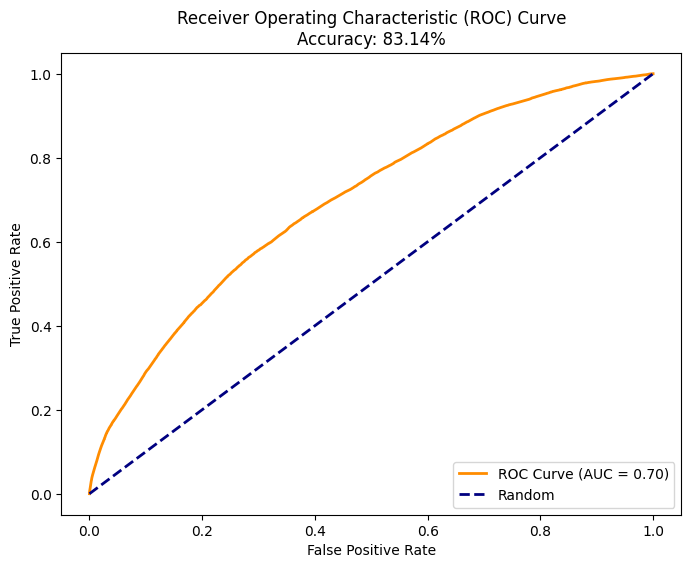

In [120]:
#plot roc curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve\nAccuracy: {:.2f}%'.format(
    accuracy * 100))
plt.legend(loc="lower right")
plt.show()

In [121]:
nll = neg_log_loss
cr = classification_report(y_test, y_pred, output_dict = True)
precision_class1 = cr['1']['precision']
recall_class1 = cr['1']['recall']
f1_class1 = cr['1']['f1-score']
power = calculate_power_from_confusion_matrix(y_test, y_pred)

In [122]:
new_row = pd.DataFrame({
    'Model': ['Logistic Regression Model'],
    'auc': [roc_auc],
    'Loss': ['negative log loss'],
    'Loss Value': [nll],
    'Precision': [precision_class1],
    'Recall': [recall_class1],
    'F1 Score': [f1_class1],
    'Power': [power]
}, index=[0])

# Append to existing metrics_df
metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

###Neural Network
1. Preprocessing
* Just like the logistic regression, we did not choose to use all parameters. We separated the parameters into high cardinality, medium cardinality, low cardinality, and continuous parameters.
* To implement the categorical features as well, we have to preprocess the categorical features by embedding dimensions. For columns with high cardinality such as site_id and app_id, I chose 64 dimensions, for cardinality, such as site_category and app_category, I chose 32 dimensions. For low cardinality, such as time_blocks and groups, I chose however many unique instances there are for that specific column. The embedding was done through sklearn's labelembedder.

2. Model architecture
* The network consists of 4 linear layers with ReLU activation functions dropout layers in between. Batch normalization was added at the start of the network with all the embedded dimensions as input to stabilize training. Although drop out was not cross validated, we did experiment with 0.1 and 0.2 and found that a dropout value of 0.2 achieved a higher performance. Finally, the output is fit onto a sigmoid function to produce the an output from 0 to 1, representing the CTR.

3. Result
* Ultimately, running 5 epochs, we were able to achieve a validation AUC of 0.767106 and a log loss of 0.389971, which are significant improvements from the logistic regression model.

In [128]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [131]:
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,weekday,site_smoothed_ctr,site_ctr_group,site_ctr_confidence,hour_sin,hour_cos,time_block,site_time_block,prev_hour_clicks,prev_hour_ctr
0,0,0,1005,0,85f751fd,c4e18dd6,50e219e0,03528b27,2347f47a,8ded1f7a,...,7,0.118783,group_6,0.999997,0.0,1.0,night,3691,8651.0,0.109236
1,0,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,3,0.205516,group_7,0.999994,0.0,1.0,night,849,3349.0,0.206032
2,0,0,1005,0,d9750ee7,98572c79,f028772b,ecad2386,7801e8d9,07d7df22,...,5,0.274174,group_8,0.999958,0.0,1.0,night,6046,495.0,0.248485
3,0,0,1005,0,ad5e6ff3,64e0e123,3e814130,ecad2386,7801e8d9,07d7df22,...,2,0.337251,group_9,0.966667,0.0,1.0,night,4825,0.0,0.171190
4,0,0,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,...,4,0.027677,group_1,0.999532,0.0,1.0,night,2248,2.0,0.500000


In [132]:
def preprocess_avazu_data(df):
    """
    Preprocess AVAZU dataset with appropriate feature selection and embeddings
    """
    # Selected features based on cardinality and importance
    high_cardinality_features = [
        'site_id','app_id','device_model'
    ]

    medium_cardinality_features = [
        'site_category', 'app_category','device_type', 'site_ctr_group'
    ]

    low_cardinality_features = [
        'hour','weekday','banner_pos','device_conn_type', 'time_block'
    ]

    continuous_features = [
        'site_smoothed_ctr','site_ctr_confidence','hour_sin','hour_cos','prev_hour_ctr'
    ]

    # Initialize dictionary to store encoders
    label_encoders = {}

    # Process categorical features
    processed_data = {}
    embedding_dims = {}

    # Process high cardinality features (64-dim embeddings)
    for feat in high_cardinality_features:
        le = LabelEncoder()
        processed_data[feat] = torch.tensor(le.fit_transform(df[feat].astype(str)))
        label_encoders[feat] = le
        embedding_dims[feat] = 64

    # Process medium cardinality features (32-dim embeddings)
    for feat in medium_cardinality_features:
        le = LabelEncoder()
        processed_data[feat] = torch.tensor(le.fit_transform(df[feat].astype(str)))
        label_encoders[feat] = le
        embedding_dims[feat] = 32

    # Process low cardinality features (nunique-dim embeddings)
    for feat in low_cardinality_features:
        le = LabelEncoder()
        processed_data[feat] = torch.tensor(le.fit_transform(df[feat].astype(str)))
        label_encoders[feat] = le
        embedding_dims[feat] = len(le.classes_)

    # Process continuous features
    continuous_tensor = torch.tensor(df[continuous_features].values, dtype=torch.float32)

    # Create feature dimensions dictionary for model initialization
    feature_dims = {
        feat: len(label_encoders[feat].classes_)
        for feat in high_cardinality_features + medium_cardinality_features + low_cardinality_features
    }

    return {
        'categorical_data': processed_data,
        'continuous_data': continuous_tensor,
        'feature_dims': feature_dims,
        'embedding_dims': embedding_dims,
        'categorical_features': high_cardinality_features + medium_cardinality_features + low_cardinality_features,
        'continuous_features': continuous_features,
        'label_encoders': label_encoders
    }

In [134]:
processed_data = preprocess_avazu_data(df)

In [140]:
class AVAZUNetwork(nn.Module):
    def __init__(self, feature_dims, embedding_dims, num_continuous):
        super().__init__()

        self.embeddings = nn.ModuleDict()
        total_embed_dim = 0

        # Create embedding layers
        for feat_name, num_unique in feature_dims.items():
            embed_dim = embedding_dims[feat_name]
            self.embeddings[feat_name] = nn.Embedding(num_unique, embed_dim)
            total_embed_dim += embed_dim

        # Add continuous features dimension
        total_embed_dim += num_continuous

        # Define feed-forward layers
        self.architecture = nn.Sequential(
            nn.BatchNorm1d(total_embed_dim),
            nn.Linear(total_embed_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, categorical_data, continuous_data):
        # Process embeddings
        embeddings = []
        for feat_name, embedding_layer in self.embeddings.items():
            embeddings.append(embedding_layer(categorical_data[feat_name]))

        # Concatenate all embeddings
        embedded = torch.cat(embeddings, dim=1)

        # Concatenate with continuous features
        combined = torch.cat([embedded, continuous_data], dim=1)

        # Pass through feed-forward layers
        return self.architecture(combined)

In [141]:
model = AVAZUNetwork(
    feature_dims=processed_data['feature_dims'],
    embedding_dims=processed_data['embedding_dims'],
    num_continuous=len(processed_data['continuous_features'])
)

categorical_data = processed_data['categorical_data']
continuous_data = processed_data['continuous_data']

In [151]:
y = df['click'].values
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

class AVAZUDataset(Dataset):
    def __init__(self, categorical_data, continuous_data, targets):
        self.categorical_data = categorical_data
        self.continuous_data = continuous_data
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        cat_sample = {k: v[idx] for k, v in self.categorical_data.items()}
        cont_sample = self.continuous_data[idx]
        target = self.targets[idx]
        return cat_sample, cont_sample, target

# Create train and validation datasets
train_dataset = AVAZUDataset(
    categorical_data=processed_data['categorical_data'],
    continuous_data=processed_data['continuous_data'],
    targets=torch.tensor(y, dtype=torch.float32)
)

val_dataset = AVAZUDataset(
    categorical_data=processed_data['categorical_data'],
    continuous_data=processed_data['continuous_data'],
    targets=torch.tensor(y, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for cat_data, cont_data, targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(cat_data, cont_data)
        loss = criterion(outputs.squeeze(), targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

In [152]:
from sklearn.metrics import roc_auc_score

In [153]:
num_epochs = 5

def validate(model, val_loader):
    model.eval()
    predictions = []
    targets_list = []

    with torch.no_grad():
        for cat_data, cont_data, targets in val_loader:
            outputs = model(cat_data, cont_data)
            predictions.extend(outputs.squeeze().cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    return roc_auc_score(targets_list, predictions)

# Modified training loop with validation
best_auc = 0
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_auc = validate(model, val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}')
    print(f'Validation AUC: {val_auc:.4f}')

    # Save best model
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/5
Train Loss: 0.3957
Validation AUC: 0.7562
Epoch 2/5
Train Loss: 0.3942
Validation AUC: 0.7590
Epoch 3/5
Train Loss: 0.3929
Validation AUC: 0.7620
Epoch 4/5
Train Loss: 0.3914
Validation AUC: 0.7639
Epoch 5/5
Train Loss: 0.3900
Validation AUC: 0.7671


In [154]:
#save best model
torch.save(model.state_dict(), 'model_parameters.pt')

In [155]:
new_row = pd.DataFrame({
    'Model': ['Neural Netork'],
    'auc': [best_auc],
    'Loss': ['negative log loss'],
    'Loss Value': [train_loss]
}, index=[0])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [158]:
metrics_df

,Model,auc,Loss,Loss Value
0,Base Logistic Regression Model,0.611000,negative log loss,0.442000
1,Logistic Regression Model,0.697078,negative log loss,0.420385
2,Neural Netork,0.767106,negative log loss,0.389971


###Decision Tree
Using the preprocessed data from the neural network section, we implement decision trees and XGBoost for the added benefit of interpretability

1. Normal Decision Tree
* We were able to achieve an AUC score of 0.74 and a log loss of 0.401.
* We were also able to look at the most important features in classification and several of the engineered features were on the list, including site_smoothed_ctr, prev_hour_ctr, and site_ctr_confidence. It is surprising to see that the temporal features such as cos and sine of hours was not as important.

2. XGBoost
* To further improve model performance, we employed XGBoost, setting the early stoppage to 10 rounds without significant improvement
* Surprisingly, we did not see significant improvement even with using XGBoost, only achieving similar figures as the normal decision tree model of log loss 0.400955 and AUC of 0.74001


In [169]:
from sklearn.tree import DecisionTreeClassifier

In [160]:
def prepare_data_for_tree(data_dict):
    # Convert categorical tensors to numpy arrays
    categorical_arrays = []
    for feature in data_dict['categorical_features']:
        cat_data = data_dict['categorical_data'][feature].numpy()
        categorical_arrays.append(cat_data)

    # Convert continuous tensor to numpy array
    continuous_array = data_dict['continuous_data'].numpy()

    # Concatenate all features
    X = np.hstack([np.stack(categorical_arrays, axis=1), continuous_array])

    # Create feature names for later interpretation
    feature_names = data_dict['categorical_features'] + data_dict['continuous_features']

    return X, feature_names

In [172]:
X, features = prepare_data_for_tree(processed_data)
y = df['click'].values

In [173]:
def train_decision_tree(X, y, feature_names):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize the model with parameters suitable for CTR prediction
    model = DecisionTreeClassifier(
        max_depth=8,
        min_samples_split=1000,
        min_samples_leaf=500,
        random_state=42
    )

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'train_logloss': log_loss(y_train, train_probs),
        'test_logloss': log_loss(y_test, test_probs),
        'train_auc': roc_auc_score(y_train, train_probs),
        'test_auc': roc_auc_score(y_test, test_probs)
    }

    # Calculate feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    return model, metrics, feature_importance, (X_train, X_test, y_train, y_test)

In [174]:
model, metrics, feature_importance, splits = train_decision_tree(X, y, features)

# Print results
print("\nModel Performance:")
for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.4f}")

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Model Performance:
train_logloss: 0.4091
test_logloss: 0.4105
train_auc: 0.7190
test_auc: 0.7182

Top 10 Most Important Features:
                feature  importance
12    site_smoothed_ctr    0.811348
4          app_category    0.045760
1                app_id    0.042565
2          device_model    0.027587
10     device_conn_type    0.024342
16        prev_hour_ctr    0.012972
5           device_type    0.011846
13  site_ctr_confidence    0.009211
8               weekday    0.004074
9            banner_pos    0.003350


In [194]:
metrics['val_auc']

0.7400123516872751

In [195]:
new_row = pd.DataFrame({
    'Model': ['Decision Tree'],
    'auc': [metrics['val_auc']],
    'Loss': ['negative log loss'],
    'Loss Value': [metrics['val_logloss']]
}, index=[0])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [196]:
metrics_df

,Model,auc,Loss,Loss Value
0,Base Logistic Regression Model,0.611000,negative log loss,0.442000
1,Logistic Regression Model,0.697078,negative log loss,0.420385
2,Neural Netork,0.767106,negative log loss,0.389971
3,Decision Tree,0.740012,negative log loss,0.400956


####XGBoost

In [171]:
from xgboost import XGBClassifier

In [180]:
def train_xgboost(X, y, feature_names):
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Initialize model
    model = XGBClassifier(
        n_estimators=1000,
        early_stopping_rounds=10,
        learning_rate=0.1,
        max_depth=8,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        eval_metric=['logloss', 'auc'],
        use_label_encoder=False,
        random_state=42
    )

    # Train with early stopping
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=50
    )

    # Make predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    val_probs = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    metrics = {
        'train_logloss': log_loss(y_train, train_probs),
        'val_logloss': log_loss(y_val, val_probs),
        'train_auc': roc_auc_score(y_train, train_probs),
        'val_auc': roc_auc_score(y_val, val_probs)
    }

    # Get feature importance
    importance = {
        'feature': feature_names,
        'importance': model.feature_importances_
    }

    return model, metrics, importance, (X_train, X_val, y_train, y_val)

In [202]:
model, metrics, importance, splits = train_xgboost(X, y, features)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [17:14:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-logloss:0.45230	validation_0-auc:0.72277	validation_1-logloss:0.45242	validation_1-auc:0.72077
[50]	validation_0-logloss:0.39952	validation_0-auc:0.74262	validation_1-logloss:0.40297	validation_1-auc:0.73617
[100]	validation_0-logloss:0.39548	validation_0-auc:0.75048	validation_1-logloss:0.40161	validation_1-auc:0.73871
[150]	validation_0-logloss:0.39224	validation_0-auc:0.75702	validation_1-logloss:0.40109	validation_1-auc:0.73976
[200]	validation_0-logloss:0.38943	validation_0-auc:0.76239	validation_1-logloss:0.40097	validation_1-auc:0.73995


In [209]:
metrics

{'train_logloss': 0.3898958715005168,
 'val_logloss': 0.4009558405604871,
 'train_auc': 0.7614889877756824,
 'val_auc': 0.7400123516872751}

In [199]:
new_row = pd.DataFrame({
    'Model': ['Decision tree (XGBoost)'],
    'auc': [metrics['val_auc']],
    'Loss': ['negative log loss'],
    'Loss Value': [metrics['val_logloss']]
}, index=[0])

metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

In [200]:
metrics_df

,Model,auc,Loss,Loss Value
0,Base Logistic Regression Model,0.611000,negative log loss,0.442000
1,Logistic Regression Model,0.697078,negative log loss,0.420385
2,Neural Netork,0.767106,negative log loss,0.389971
3,Decision Tree,0.740012,negative log loss,0.400956
4,Decision tree (XGBoost),0.740012,negative log loss,0.400956


###Future Work direction: Attempt Model Blending

##Conclusion
Overall, the neural network worked best, achieving an AUC of 0.767 and a negative log loss of 0.389. Our hypothesis is that
1. the neural network was best at learning complex temporal dependencies.
2. The high dimensionality nature of the dataset, in addition to choosing an appropriate number of embedding for the features that contain a lot of unique values.
3. We could maybe play around with the tree depth to see if there are any improvements to the model. Since the dataset is sizable, we have less of a risk of overfitting.
4. Through the multiple layers, the neural network was able to learn higher level representations of the data, allowing it to classify more effectively.
5. Since the cardinality of several of the features was very high, it makes it very difficult to conduct one hot encoding, which is extremely beneficial to tree based models.

In [201]:
metrics_df

,Model,auc,Loss,Loss Value
0,Base Logistic Regression Model,0.611000,negative log loss,0.442000
1,Logistic Regression Model,0.697078,negative log loss,0.420385
2,Neural Netork,0.767106,negative log loss,0.389971
3,Decision Tree,0.740012,negative log loss,0.400956
4,Decision tree (XGBoost),0.740012,negative log loss,0.400956
